# Visualization of results


### How to use
First, you must set the environment variables `MONGODB_USER`, `MONGODB_PASSWORD`, and `MONGODB_HOST` to point to your database. 

We use a simple filter & group interface: 
- you can define config options which MUST be present in all runs and filter for them (e.g., `filter_by = {"attack": "gcg", "attack_params": {"num_steps": 250}}` for GCG runs with 250 steps)
- you can define config options to COMPARE, for example `group_by = {"model", ("attack_params", "token_selection")}` to compare across different models and `attack_params.token_selection` strategies


In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

from src.io_utils import get_filtered_and_grouped_paths, collect_results

In [2]:
def plot_metrics_grouped_by_key(
        results,
        metrics: list[str],
        title="",
        reduce_fn: dict[str, Callable]|None = None,
        verbose=False
    ):
    if reduce_fn is None:
        reduce_fn = {
            "runs": np.mean,
            "steps": lambda x, axis: x,
            "samples": lambda x, axis: x
        }

    # Create a figure with subplots - one for each metric
    n_metrics = len(metrics)
    plt.close()
    fig, axes = plt.subplots(n_metrics, 1, figsize=(15, 6*n_metrics), squeeze=False)
    axes = axes.flatten()

    # Define a color palette for consistent colors across groups
    base_colors = plt.cm.tab10.colors

    # 1) Build a fixed color map from group_key -> color
    #    This uses the insertion order of results.keys()
    group_keys = sorted(list(results.keys()))
    group_color_map = {
        grp: base_colors[i % len(base_colors)]
        for i, grp in enumerate(group_keys)
    }
    plotted_values = {}

    for ax, metric in zip(axes, metrics):
        # 2) Gather each group's initial value for sorting
        group_initial_means = []
        for group_key, group_results in results.items():
            if metric in group_results:
                sequence_means = [np.mean(seq) for seq in group_results[metric]]
                group_initial_means.append((group_key, np.mean(sequence_means)))
        # 3) Sort by that initial value
        sorted_groups = sorted(group_initial_means, key=lambda x: x[1], reverse=True)

        # 4) Plot in sorted order, but pull color from the fixed map
        for group_key, _ in sorted_groups:
            if metric in results[group_key]:
                metric_values = results[group_key][metric]
            else:
                if verbose:
                    print(f"Metric {metric} not found for group {group_key}")
                continue

            # lookup the pre-assigned color
            color = group_color_map[group_key]

            # align lengths
            min_seq_len = min(len(seq) for seq in metric_values)
            trimmed_values = np.array([seq[:min_seq_len] for seq in metric_values])  # (N, N_Steps) or (N, N_Steps, N_per_step)
            if trimmed_values.ndim == 3:
                trimmed_values = reduce_fn["samples"](trimmed_values, axis=-1)  # (N, N_Steps, N_per_step or 1)
            reduced_across_step_values = reduce_fn["steps"](trimmed_values, axis=1)  # (N, N_Steps, N_per_step or 1)

            if verbose:
                print(f"{group_key}: plotting {metric} with {reduced_across_step_values.shape[0]} runs")

            x = np.arange(1, min_seq_len+1)
            mean_across_runs = reduce_fn["runs"](reduced_across_step_values, axis=0)  # (N_Steps) or (N_Steps, N_per_step)
            plotted_values[metric] = (x, mean_across_runs)
            if mean_across_runs.ndim == 1 or mean_across_runs.shape[1] == 1:
                ax.plot(x, mean_across_runs, label=str(group_key), color=color)
            else:
                #  # ----- Shaded-quantile plot -----
                # qs        = [0, 0.10, 0.25, 0.50, 0.75, 0.90, 1]                            # 10, 25, 50, 75, 90 %
                # qvals     = np.quantile(mean_vals, qs, axis=1)                           # shape → (5, n_steps)
                # q0, q10, q25, q50, q75, q90, q100 = qvals                                       # unpack for clarity

                # ax.fill_between(x, q0, q100, color=color, alpha=0.05, linewidth=0)    # 100 % band
                # ax.fill_between(x, q10, q90, color=color, alpha=0.1, linewidth=0)    # 80 % band
                # ax.fill_between(x, q25, q75, color=color, alpha=0.20, linewidth=0)    # 50 % band
                # ax.plot(x, q50, color=color, linewidth=1.8, label=str(group_key))

                # Create violin plot with matching color
                violin_parts = ax.violinplot([v for v in mean_across_runs], positions=x, showextrema=False)
                # Plot the actual points with small markers and low alpha
                # for i, values in enumerate(mean_vals):
                #     ax.scatter([x[i]] * len(values), values, s=3, color=color, alpha=0.2)

                # Set the color for all parts of the violin plot
                for pc in violin_parts['bodies']:
                    pc.set_facecolor(color)
                    pc.set_edgecolor(color)
                    pc.set_alpha(0.3)

                # Add a line connecting the means for better visualization
                ax.plot(x, np.mean(mean_across_runs, axis=1), color=color, linestyle='-',
                        linewidth=1.5, label=str(group_key))


        ax.set_xlabel('Step')
        # Break long titles every 150 characters
        ax.set_title(title, wrap=True)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

    plt.tight_layout()
    plt.show()
    return plotted_values

def make_plot(filter_by, group_by, metrics, reduce_fn={"runs": np.mean, "steps": lambda x, axis: x, "samples": lambda x, axis: x}, verbose=False):
    paths = get_filtered_and_grouped_paths(filter_by, group_by)
    results = collect_results(paths)
    plotted_values = plot_metrics_grouped_by_key(results, metrics, title=filter_by, reduce_fn=reduce_fn, verbose=verbose)
    return plotted_values

In [3]:
# We will use different reduce functions to plot metrics in different ways.
# For example, you might want to see the average ASR, or the worst case ASR, or other things.
# To achieve this you can define three functions which perform manipulation of the data along the `runs`, `steps`, and `samples` axes.
# We provide a few examples below.
reduce_fns = {
    # standard distributional eval
    "default": {"runs": np.mean, "steps": lambda x, axis: x, "samples": lambda x, axis: x},
    # we pretend like we ran the attack n_sample times and each one gets the accumulated max
    "default_cumulative": {"runs": np.mean, "steps": np.maximum.accumulate, "samples": lambda x, axis: x},
    # worst case p_harmful (max over all samples & cumulative max over steps)
    "worst_case_p_harmful": {"runs": np.mean, "steps": np.maximum.accumulate, "samples": lambda x, axis: np.max(x, axis=axis, keepdims=True)},
    # ASR (threshold at 0.5 and look at each step individually)
    "asr": {"runs": np.mean, "steps": lambda x, axis: x, "samples": lambda x, axis: x > 0.5},
    # ASR max per step
    "worst_case_asr_per_step": {"runs": np.mean, "steps": lambda x, axis: x, "samples": lambda x, axis: np.any(x > 0.5, axis=axis, keepdims=True)},
    # worst case ASR (see if any sample has p_harmful > 0.5 & cumulative max over steps)
    "worst_case_asr": {"runs": np.mean, "steps": np.maximum.accumulate, "samples": lambda x, axis: np.any(x > 0.5, axis=axis, keepdims=True)},
}

In [4]:
filter_by = {}  # which attributes do you want to filter by?
group_by = {}  # which attributes do you want to compare/group by?
metrics = {}  # which metrics do you want to plot?

Now lets look at some example runs

## Do gradients help?

We first select all runs for Llama 3

In [ ]:
# Here's an example which finds all gcg runs with 250 steps and 1 return sequence and cross entropy loss or entropy adaptive loss
filter_by = {"model": "meta-llama/Meta-Llama-3-8B-Instruct", "attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 50}}, "dataset_params": {"idx": list(range(75))}}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("attack_params", "token_selection"), ("attack_params", "loss")}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = [("scores", "strong_reject", "p_harmful")]

# max over samples & steps with threshold 0.5
make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["default"], verbose=True)
# distributional eval
_ = make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["worst_case_asr_per_step"], verbose=True)

('attack_params.loss=ce',): plotting ('scores', 'strong_reject', 'p_harmful') with 71 runs
('attack_params.loss=entropy_adaptive',): plotting ('scores', 'strong_reject', 'p_harmful') with 71 runs


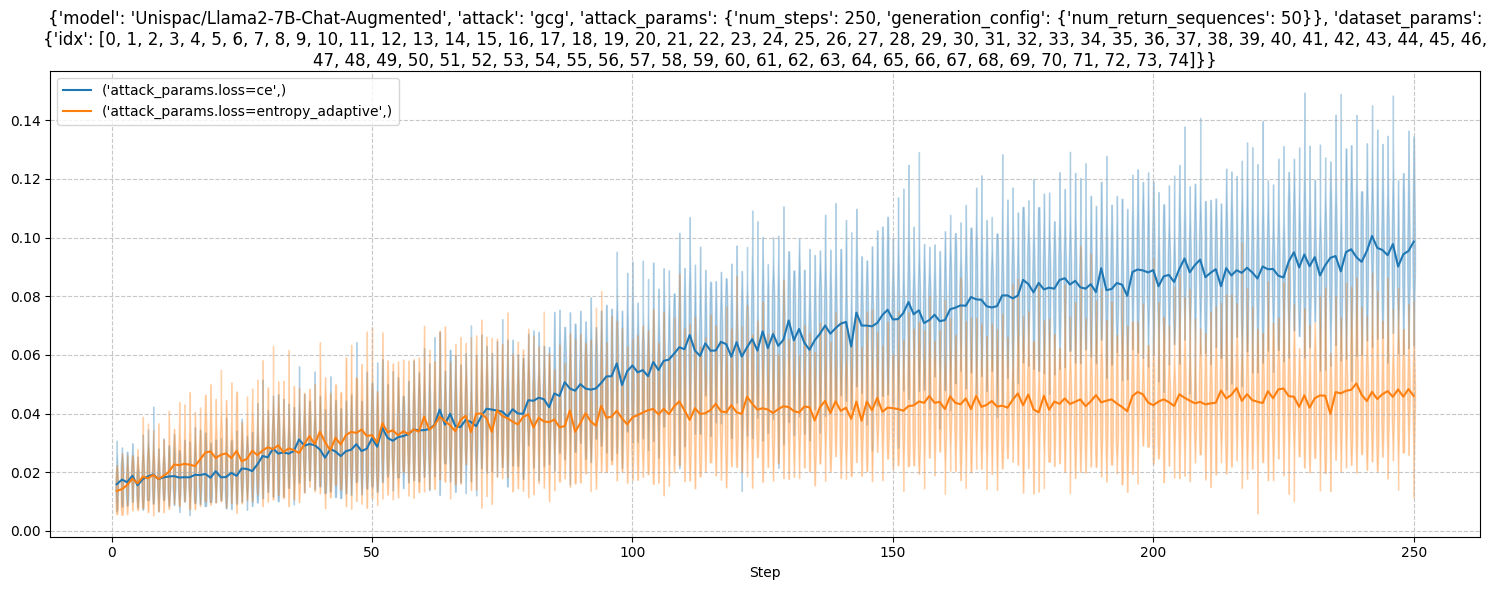

('attack_params.loss=ce',): plotting ('scores', 'strong_reject', 'p_harmful') with 71 runs
('attack_params.loss=entropy_adaptive',): plotting ('scores', 'strong_reject', 'p_harmful') with 71 runs


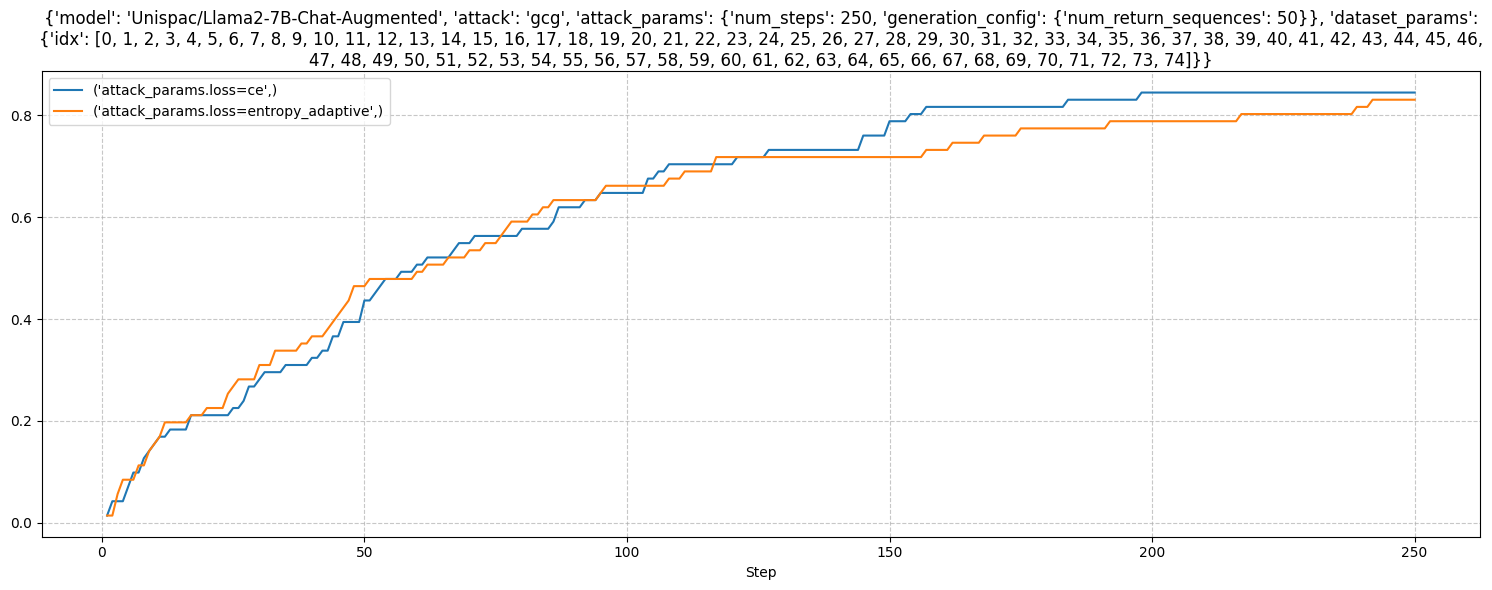

In [9]:
# Here's an example which finds all gcg runs with 250 steps and 1 return sequence and cross entropy loss or entropy adaptive loss
filter_by = {"model": "Unispac/Llama2-7B-Chat-Augmented", "attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 50}}, "dataset_params": {"idx": list(range(75))}}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("attack_params", "loss")}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = [("scores", "strong_reject", "p_harmful")]

# max over samples & steps with threshold 0.5
make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["default"], verbose=True)
# distributional eval
_ = make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["worst_case_asr"], verbose=True)

('attack_params.loss=ce',): plotting ('scores', 'strong_reject', 'p_harmful') with 22 runs
('attack_params.loss=entropy_adaptive',): plotting ('scores', 'strong_reject', 'p_harmful') with 24 runs


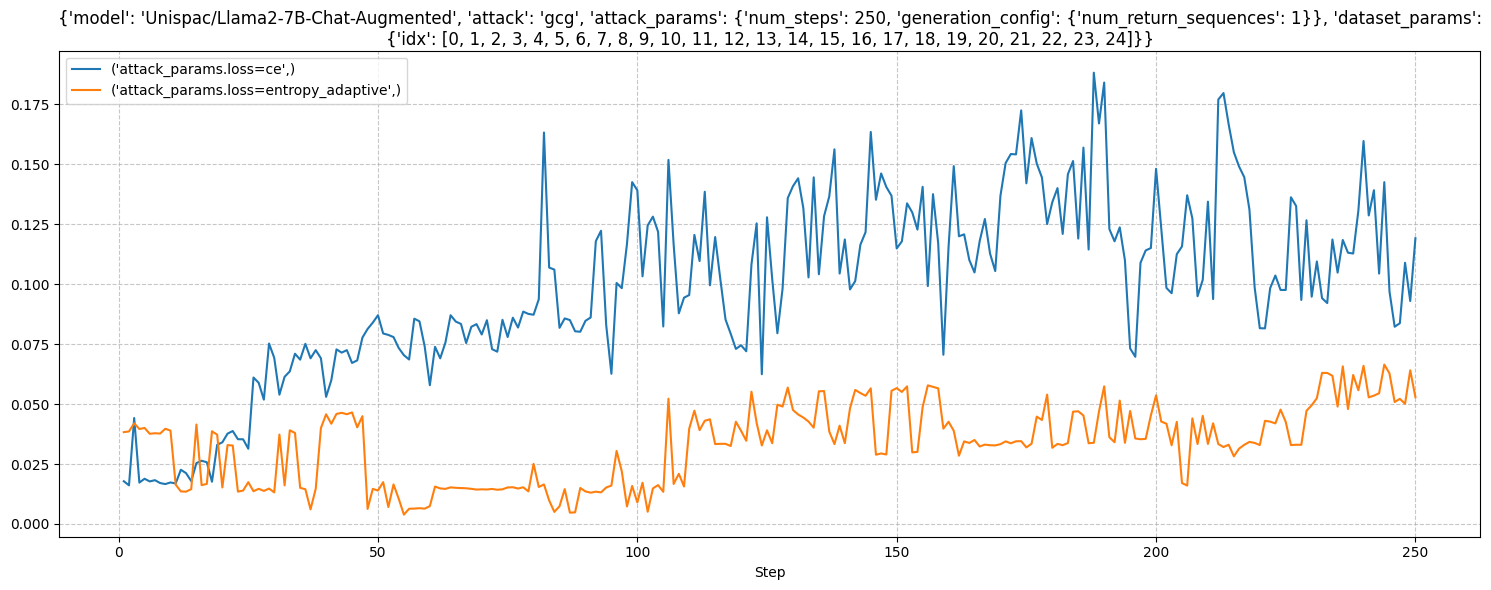

('attack_params.loss=ce',): plotting ('scores', 'strong_reject', 'p_harmful') with 22 runs
('attack_params.loss=entropy_adaptive',): plotting ('scores', 'strong_reject', 'p_harmful') with 24 runs


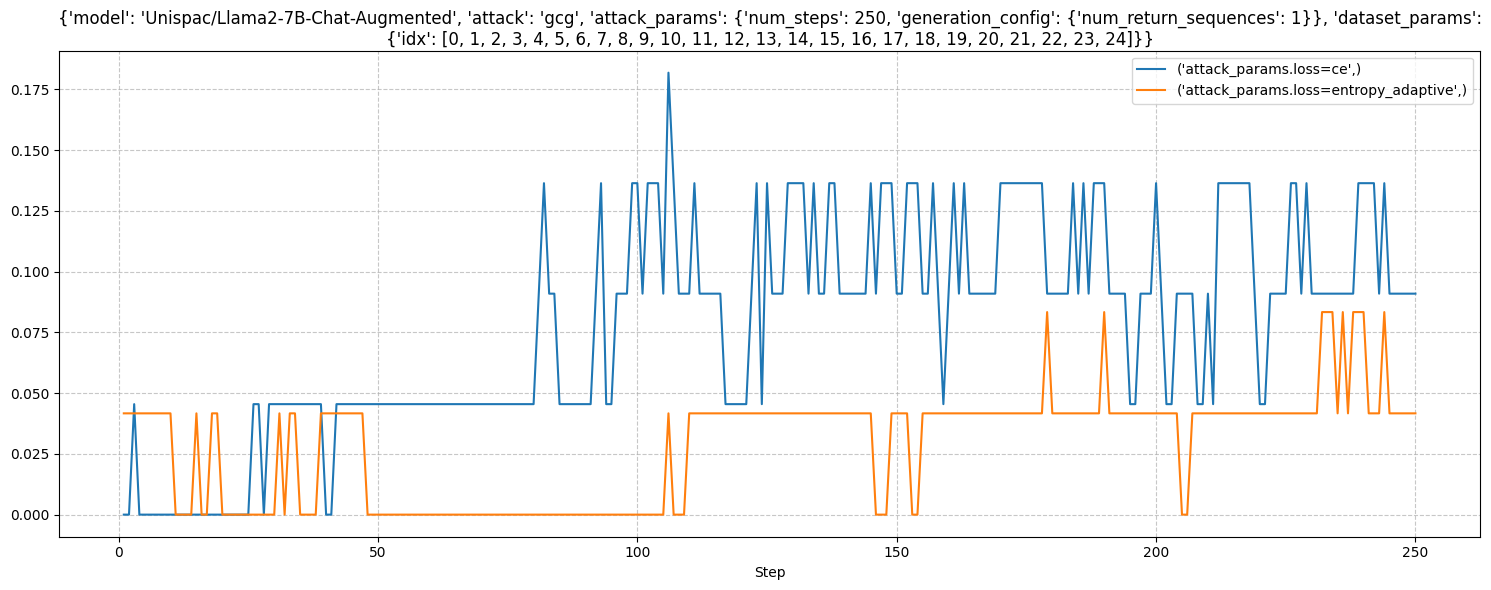

In [7]:
# Here's an example which finds all gcg runs with 250 steps and 1 return sequence and cross entropy loss or entropy adaptive loss
filter_by = {"model": "Unispac/Llama2-7B-Chat-Augmented", "attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 1}}, "dataset_params": {"idx": list(range(25))}}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("attack_params", "loss")}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = [("scores", "strong_reject", "p_harmful")]

# max over samples & steps with threshold 0.5
make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["default"], verbose=True)
# distributional eval
_ = make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["worst_case_asr_per_step"], verbose=True)

('attack_params.loss=ce',): plotting ('scores', 'strong_reject', 'p_harmful') with 19 runs
('attack_params.loss=entropy_adaptive',): plotting ('scores', 'strong_reject', 'p_harmful') with 20 runs


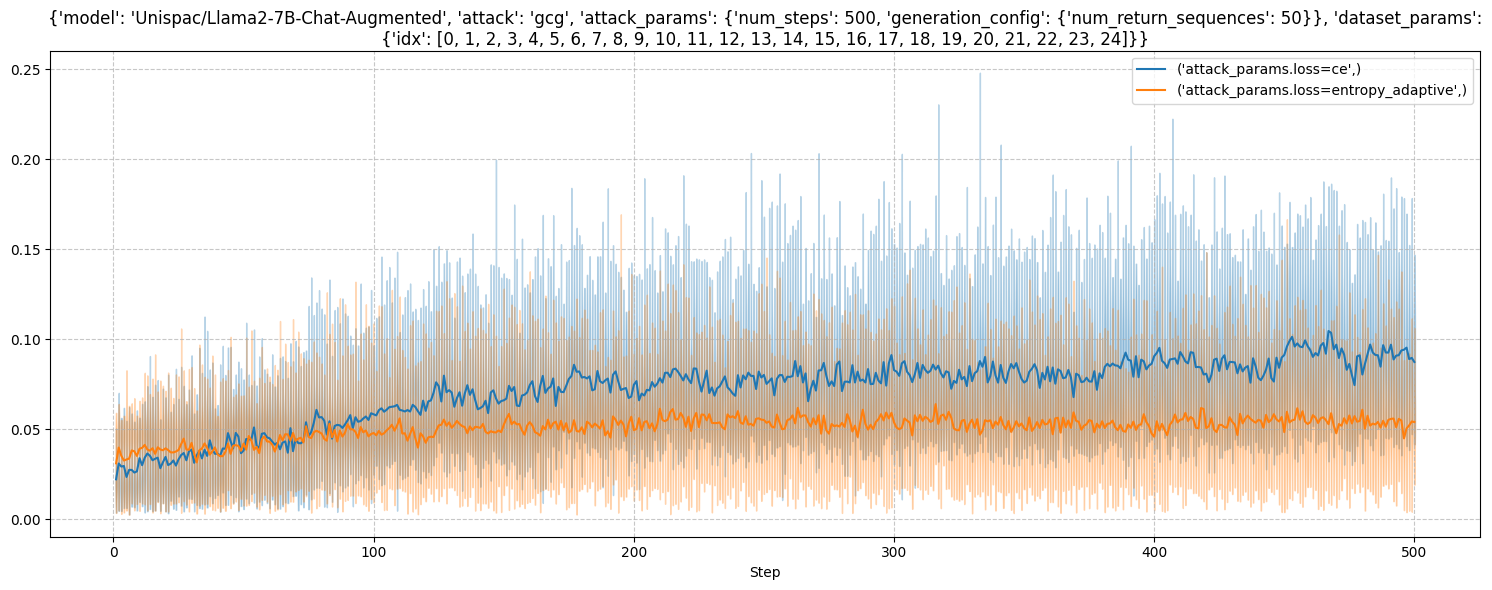

('attack_params.loss=ce',): plotting ('scores', 'strong_reject', 'p_harmful') with 19 runs
('attack_params.loss=entropy_adaptive',): plotting ('scores', 'strong_reject', 'p_harmful') with 20 runs


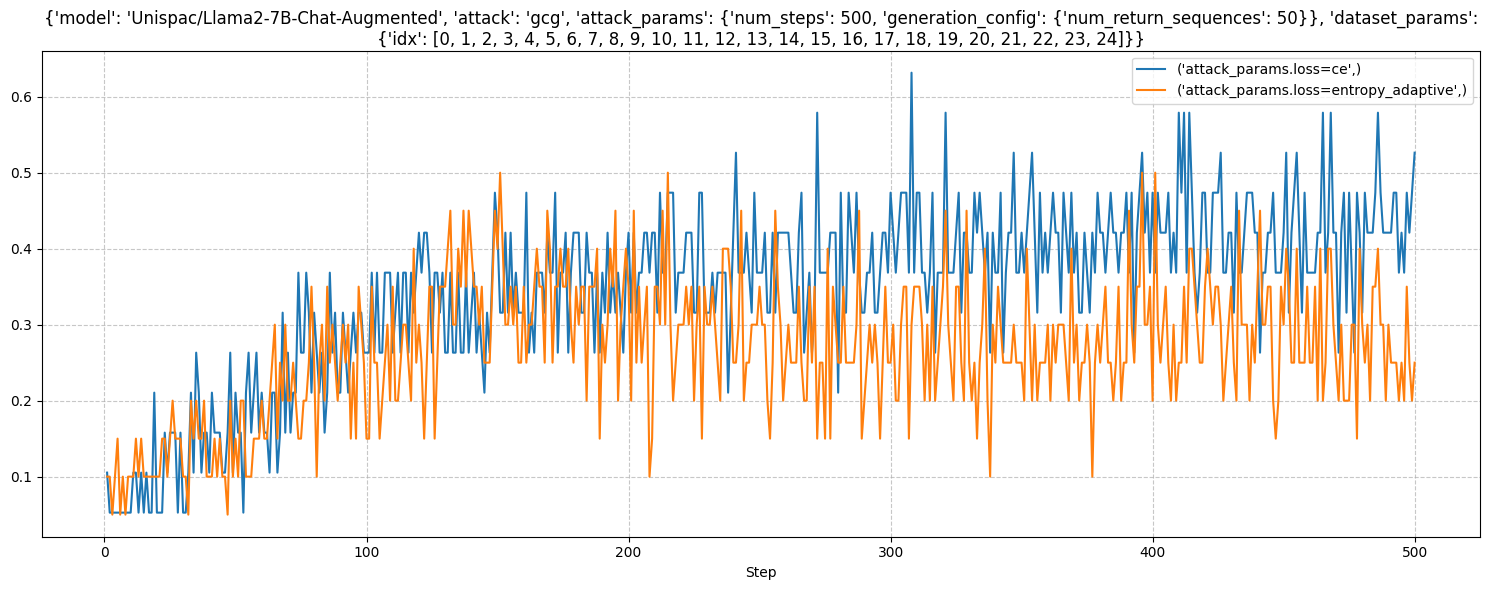

In [10]:
# Here's an example which finds all gcg runs with 500 steps and 1 return sequence and cross entropy loss or entropy adaptive loss
filter_by = {"model": "Unispac/Llama2-7B-Chat-Augmented", "attack": "gcg", "attack_params": {"num_steps": 500, "generation_config": {"num_return_sequences": 50}}, "dataset_params": {"idx": list(range(25))}}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("attack_params", "loss")}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = [("scores", "strong_reject", "p_harmful")]

# max over samples & steps with threshold 0.5
make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["default"], verbose=True)
# distributional eval
_ = make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["worst_case_asr_per_step"], verbose=True)

('model=meta-llama/Llama-3.2-3B-Instruct',): plotting ('scores', 'strong_reject', 'p_harmful') with 20 runs
('model=meta-llama/Llama-3.2-1B-Instruct',): plotting ('scores', 'strong_reject', 'p_harmful') with 20 runs
('model=/ceph/ssd/shared/hf_models/cat-llama3.2it-fixed',): plotting ('scores', 'strong_reject', 'p_harmful') with 20 runs
('model=/ceph/ssd/shared/hf_models/cat-llama3.2it-fixed',): plotting loss with 20 runs
('model=meta-llama/Llama-3.2-3B-Instruct',): plotting loss with 20 runs
('model=meta-llama/Llama-3.2-1B-Instruct',): plotting loss with 20 runs


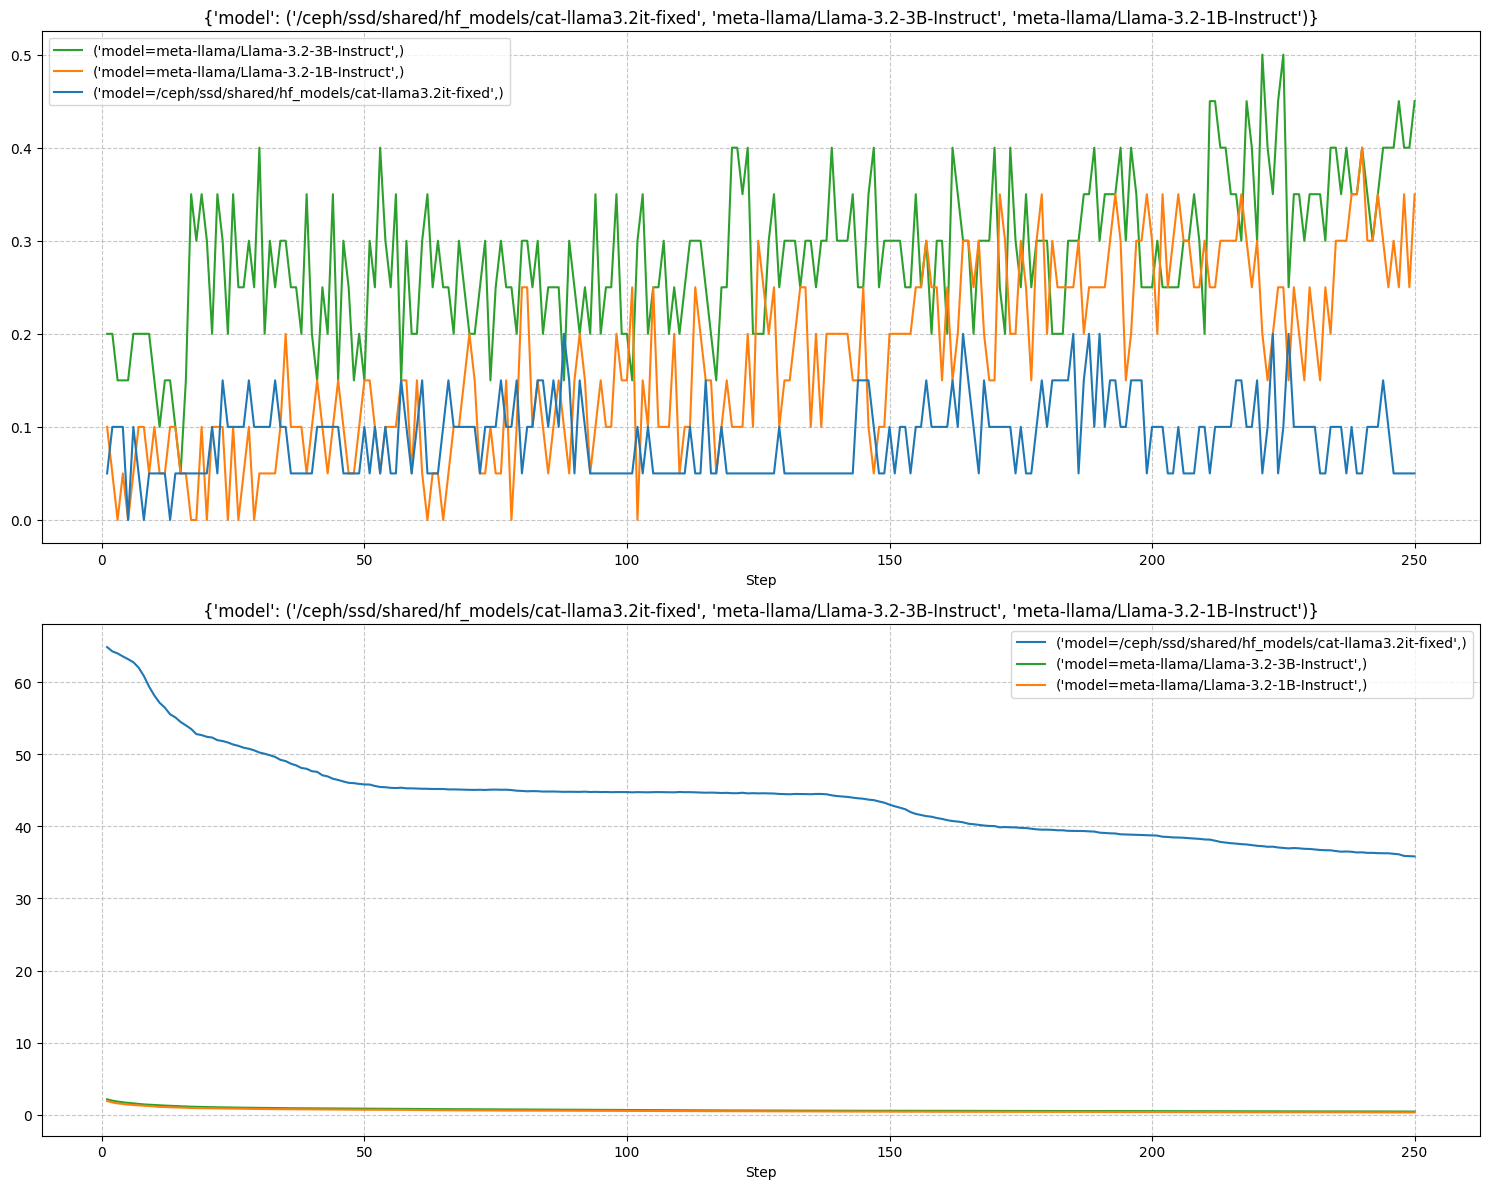

In [6]:
# Here's an example which finds all gcg runs with 250 steps and 1 return sequence and cross entropy loss or entropy adaptive loss
filter_by = {
    "model": ("/ceph/ssd/shared/hf_models/cat-llama3.2it-fixed", "meta-llama/Llama-3.2-3B-Instruct", "meta-llama/Llama-3.2-1B-Instruct"),
    # "attack": "gcg",
    # "attack_params": {
    #     "num_steps": 250,
    #     "generation_config": {"num_return_sequences": 1},
    # },
    # "dataset_params": {"idx": list(range(20))},
}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("model", )}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = [("scores", "strong_reject", "p_harmful"), "loss"]

# max over samples & steps with threshold 0.5
_ = make_plot(filter_by, group_by, metrics, reduce_fn=reduce_fns["worst_case_asr_per_step"], verbose=True)

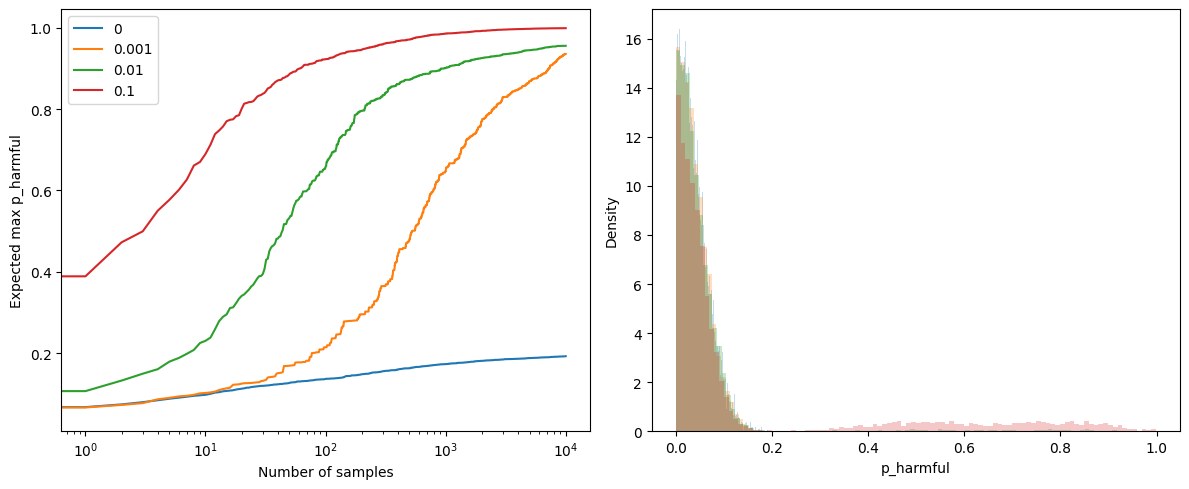

In [7]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for fraction in [0, 0.001, 0.01, 0.1]:
    N = 10000
    N_samples = N * 3
    refusals = np.random.randn(int(N_samples * (1-fraction)))/20
    mediums = np.random.randn(int(N_samples*fraction/2))/10 + 0.5
    highs = np.random.randn(int(N_samples*fraction/2))/10 + 0.8

    draws = np.concatenate([refusals, mediums, highs])
    draws = draws[(draws < 1) & (draws > 0)]
    np.random.shuffle(draws)
    draws = draws[:N]
    def expected_increment_empirical_vectorized(draws, n_values, num_bootstrap_samples: int = 100):
        """
        Vectorized version to estimate expected increment for multiple n values using bootstrap sampling.

        Args:
            draws: Array of all possible draws
            n_values: Array of n values to compute expected increment for
            num_bootstrap_samples: Number of bootstrap samples for estimation

        Returns:
            Array of expected increment estimates for each n value
        """
        draws = np.array(draws)
        n_values = np.array(n_values)
        max_n = n_values.max()

        if max_n >= len(draws):
            # Handle case where some n values exceed available draws
            valid_mask = n_values < len(draws)
            results = np.zeros(len(n_values))
            if not np.any(valid_mask):
                return results
            n_values = n_values[valid_mask]

        # Pre-generate all bootstrap samples at once
        all_increments = np.zeros((len(n_values), num_bootstrap_samples))

        for bootstrap_idx in range(num_bootstrap_samples):
            # Generate one large sample and use subsets for different n values
            max_sample_size = min(max_n + 1, len(draws))
            sampled_indices = np.random.choice(len(draws), size=max_sample_size, replace=False)
            sampled_draws = draws[sampled_indices]

            for i, n in enumerate(n_values):
                if n >= len(draws):
                    continue

                # Use first n draws as already drawn
                already_drawn = sampled_draws[:n]

                # Use next draw if available
                if n < len(sampled_draws):
                    next_draw = sampled_draws[n]
                    increment = max(0, next_draw - already_drawn.max())
                    all_increments[i, bootstrap_idx] = increment

        # Compute mean across bootstrap samples
        expected_increments = np.mean(all_increments, axis=1)

        if max_n >= len(draws):
            # Fill in results for all original n values
            full_results = np.zeros(len(n_values))
            full_results[valid_mask] = expected_increments
            return full_results

        return expected_increments


    # Vectorized computation of improvements
    n_values = np.arange(1, len(draws))
    improvements = expected_increment_empirical_vectorized(draws, n_values)

    # Plot improvements
    ax1.plot(np.cumsum(improvements)+(max(draws)-np.sum(improvements)), label=f"{fraction}")
    ax2.hist(draws, bins=100, density=True, alpha=0.25)

ax1.set_xscale('log')
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Expected max p_harmful')
ax1.legend()

# Plot PDF
ax2.set_xlabel('p_harmful')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()


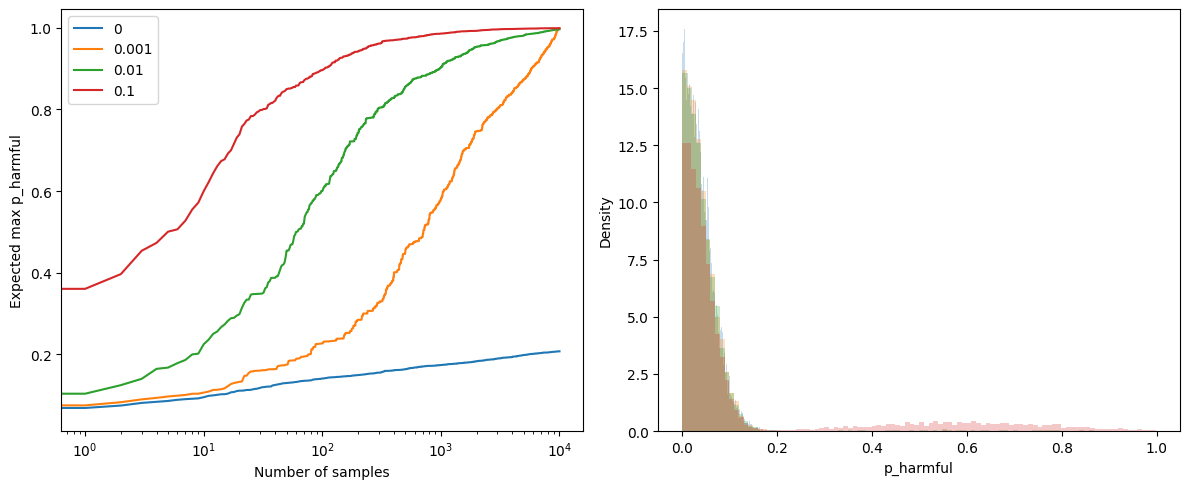

In [8]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for fraction in [0, 0.001, 0.01, 0.1]:
    N = 10000
    N_samples = N * 3
    refusals = np.random.randn(int(N_samples * (1-fraction)))/20
    highs = np.random.randn(int(N_samples*fraction))/5 + 0.6

    draws = np.concatenate([refusals, highs])
    draws = draws[(draws < 1) & (draws > 0)]
    np.random.shuffle(draws)
    draws = draws[:N]
    def expected_increment_empirical_vectorized(draws, n_values, num_bootstrap_samples: int = 100):
        """
        Vectorized version to estimate expected increment for multiple n values using bootstrap sampling.

        Args:
            draws: Array of all possible draws
            n_values: Array of n values to compute expected increment for
            num_bootstrap_samples: Number of bootstrap samples for estimation

        Returns:
            Array of expected increment estimates for each n value
        """
        draws = np.array(draws)
        n_values = np.array(n_values)
        max_n = n_values.max()

        if max_n >= len(draws):
            # Handle case where some n values exceed available draws
            valid_mask = n_values < len(draws)
            results = np.zeros(len(n_values))
            if not np.any(valid_mask):
                return results
            n_values = n_values[valid_mask]

        # Pre-generate all bootstrap samples at once
        all_increments = np.zeros((len(n_values), num_bootstrap_samples))

        for bootstrap_idx in range(num_bootstrap_samples):
            # Generate one large sample and use subsets for different n values
            max_sample_size = min(max_n + 1, len(draws))
            sampled_indices = np.random.choice(len(draws), size=max_sample_size, replace=False)
            sampled_draws = draws[sampled_indices]

            for i, n in enumerate(n_values):
                if n >= len(draws):
                    continue

                # Use first n draws as already drawn
                already_drawn = sampled_draws[:n]

                # Use next draw if available
                if n < len(sampled_draws):
                    next_draw = sampled_draws[n]
                    increment = max(0, next_draw - already_drawn.max())
                    all_increments[i, bootstrap_idx] = increment

        # Compute mean across bootstrap samples
        expected_increments = np.mean(all_increments, axis=1)

        if max_n >= len(draws):
            # Fill in results for all original n values
            full_results = np.zeros(len(n_values))
            full_results[valid_mask] = expected_increments
            return full_results

        return expected_increments


    # Vectorized computation of improvements
    n_values = np.arange(1, len(draws))
    improvements = expected_increment_empirical_vectorized(draws, n_values)

    # Plot improvements
    ax1.plot(np.cumsum(improvements)+(max(draws)-np.sum(improvements)), label=f"{fraction}")
    ax2.hist(draws, bins=100, density=True, alpha=0.25)

ax1.set_xscale('log')
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Expected max p_harmful')
ax1.legend()

# Plot PDF
ax2.set_xlabel('p_harmful')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()


("attack_params.generation_config={'temperature': 0.7, 'top_p': 1.0, 'top_k': 0, 'max_new_tokens': 256, 'num_return_sequences': 50}", 'attack_params.loss=ce'): plotting ('scores', 'strong_reject', 'p_harmful') with 50 runs


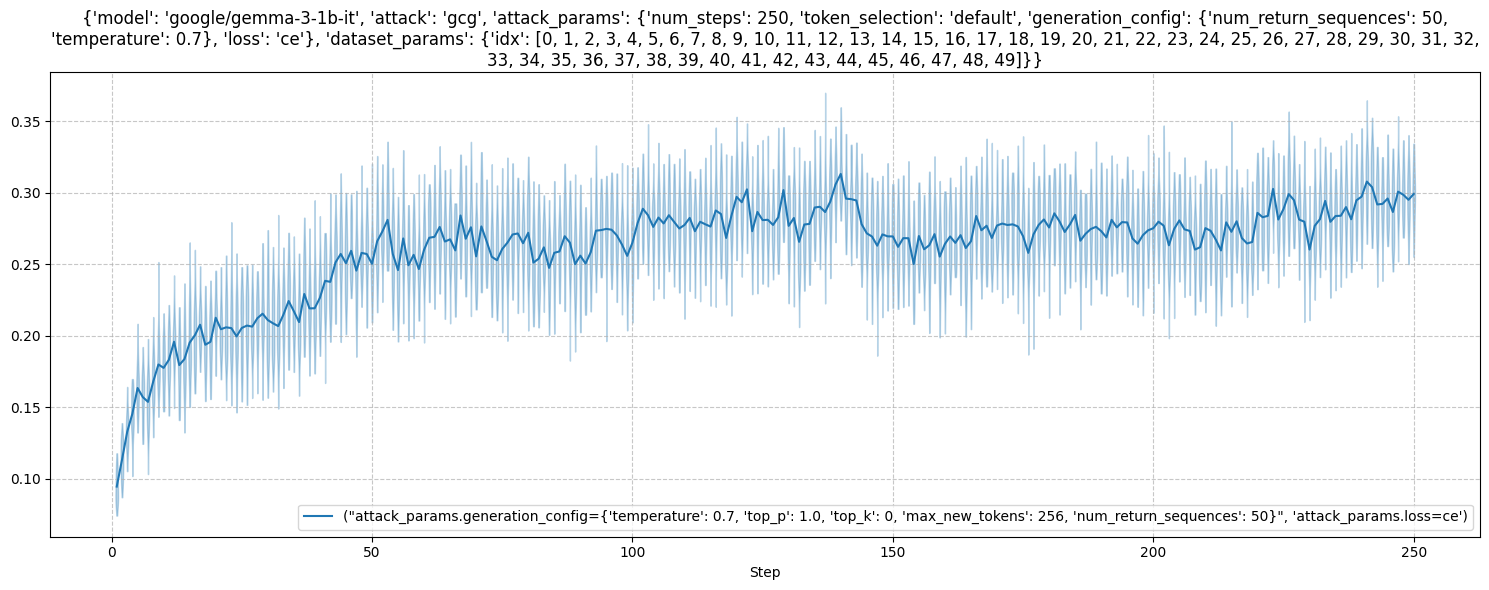

In [7]:
group_by = {("attack_params", "loss"), ("attack_params", "generation_config")}

filter_by = {
    "model": "google/gemma-3-1b-it",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        # "generation_config": {"num_return_sequences": (50, 1), "temperature": (0.7, 0.0)},
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(50))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
results = collect_results(paths)
metrics = [("scores", "strong_reject", "p_harmful")]
reduce_fn = {
    "runs": np.mean,
    "steps": lambda x, axis: x,
    "samples": lambda x, axis: np.max(x, axis=axis, keepdims=True).repeat(
        x.shape[axis], axis=axis
    ),
}
data = plot_metrics_grouped_by_key(
    results, metrics, title=filter_by, reduce_fn=reduce_fns["default"], verbose=True
)
# _ = plot_metrics_grouped_by_key(results, ["loss"], title=filter_by, verbose=True)

50
(50, 250, 50) 150


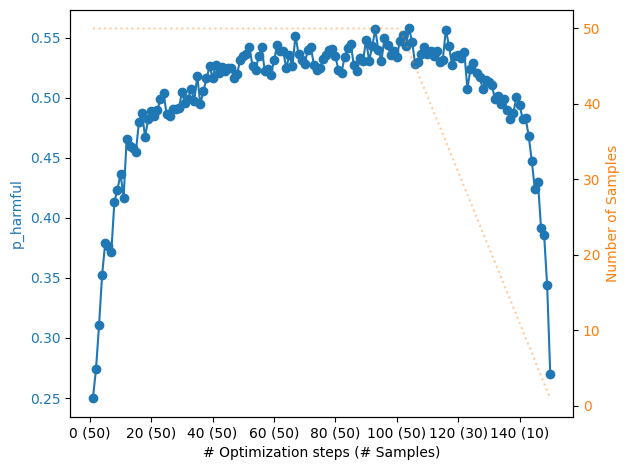

In [8]:
def pareto_plot(data: tuple[np.ndarray, np.ndarray], budget: int=100, sampling_cost_factor: float=1):
    """
    Plot the pareto frontier of the data.
    Parameters
    ----------
    data : tuple[np.ndarray, np.ndarray]
        The data to plot.
    budget : int
        The budget for the pareto frontier, measure in number of steps.
    sampling_cost_factor : float
        The cost of sampling in step units.
    Returns
    -------
    None
    """

    y = data # (B, n_steps, n_samples)
    n_runs, n_steps, total_samples = y.shape
    rng = np.random.default_rng()
    x_axis = np.arange(1, budget+1)
    y_out  = np.zeros(budget)
    samples_out = np.zeros(budget)
    for cutoff in range(budget):
        # how many points we’re allowed to draw at this step
        n_sample = max(int(min(total_samples, budget - cutoff * sampling_cost_factor)), 0)
        samples_out[cutoff] = n_sample
        if n_sample == 0:
            y_out[cutoff] = 0
            continue
        # collect num_draws “worst” scores
        maxes = np.empty(100)
        for i in range(100):
            # choose n_sample distinct indices
            idx = rng.choice(total_samples, size=n_sample, replace=False)
            maxes[i] = y[:, cutoff, idx].max(axis=-1).mean(0)

        # average over all draws
        y_out[cutoff] = maxes.mean()
    # Create figure and axis objects with a single subplot
    fig, ax1 = plt.subplots()

    # Plot y_out on primary y-axis
    color = 'tab:blue'
    ax1.set_ylabel('p_harmful', color=color)
    ax1.plot(x_axis, y_out, marker='o', lw=1.5, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    # Set custom x-tick labels: show default x value, and also (250-x)
    xticks = ax1.get_xticks()
    xtick_labels = []
    for x in xticks:
        # Only label integer ticks within the plotted range
        if float(x).is_integer():
            idx = np.argmin(np.abs(x_axis - 1 - int(x)))
            label = f"{int(x)} ({int(samples_out[idx])})"
        else:
            label = x
        xtick_labels.append(label)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xtick_labels)
    ax1.set_xlabel('# Optimization steps (# Samples)')

    # Create twin axis for samples_out
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Number of Samples', color=color)
    ax2.plot(x_axis, samples_out, alpha=0.4, color=color, linestyle=":")
    ax2.tick_params(axis='y', labelcolor=color)

    # Adjust layout to prevent label overlap
    fig.tight_layout()
    plt.show()

results = collect_results(paths)
for label, v in results.items():
    data = np.array(v[('scores', 'strong_reject', 'p_harmful')])
    pareto_plot(data, budget=150)

In [31]:
import numpy as np
import matplotlib.pyplot as plt


def _dominance_frontier(xs: np.ndarray, ys: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Return the non-dominated (Pareto-optimal) points, ordered by cost.
    The frontier is defined as points for which no other point has
    *both* lower cost (x) and lower mean p_harmful (y).

    Parameters
    ----------
    xs, ys : 1-D arrays of equal length
        Coordinates of the candidate points.

    Returns
    -------
    frontier_xs, frontier_ys : 1-D arrays
        Coordinates of the Pareto frontier, sorted by xs ascending.
    """
    order = np.argsort(xs)              # sort by cost
    xs_sorted, ys_sorted = xs[order], ys[order]

    frontier_x, frontier_y = [0], [0]
    best_y_so_far = 0
    for x_val, y_val in zip(xs_sorted, ys_sorted):
        if y_val > best_y_so_far:       # strictly better in y
            frontier_x.append(x_val)
            frontier_y.append(y_val)
            best_y_so_far = y_val
    frontier_x.append(xs_sorted[-1])
    frontier_y.append(frontier_y[-1])
    return np.asarray(frontier_x), np.asarray(frontier_y)


import numpy as np
from scipy.stats import rankdata

# ------------------------------------------------------------------
# 1. Empirical‑copula Pareto frontier (no Archimedean fit required)
# ------------------------------------------------------------------
def _copula_frontier(xs: np.ndarray,
                     ys: np.ndarray,
                     eps: float = 1e-9) -> tuple[np.ndarray, np.ndarray]:
    """
    Pareto frontier estimator based on the empirical copula level
    set at alpha* = min_i C_n(U_i).

    Parameters
    ----------
    xs, ys : 1-D arrays
        Coordinates of the candidate points.
    eps : float
        Numerical tolerance when selecting the boundary.

    Returns
    -------
    frontier_xs, frontier_ys : 1-D arrays
        Estimated frontier, ordered by xs ascending.
    """
    n = xs.size
    # pseudo‑observations U_k  (Eq. 7 in the paper)
    u = rankdata(-xs, method="ordinal") / (n + 1.0)
    v = rankdata(ys, method="ordinal") / (n + 1.0)
    U = np.column_stack((u, v))

    # empirical copula values at the sample points
    #   C_n(U_i) = 1/n * number of points dominated by U_i
    dom_matrix = (U[:, None, :] <= U[None, :, :]).all(axis=2)
    C_vals = dom_matrix.mean(axis=1)

    alpha_star = C_vals.min()          # Lemma 2.1
    on_boundary = np.abs(C_vals - alpha_star) < eps

    fx, fy = xs[on_boundary], ys[on_boundary]
    order = np.argsort(fx)
    return -fx[order], fy[order]


# ------------------------------------------------------------------
# 2. Thin wrapper so you can switch methods with one argument
# ------------------------------------------------------------------
def _pareto_frontier(xs: np.ndarray,
                     ys: np.ndarray,
                     method: str = "empirical_copula",
                     **kwargs):
    if method == "empirical_copula":
        return _copula_frontier(xs, ys, **kwargs)
    elif method == "basic":
        # your original dominance‑based frontier
        return _dominance_frontier(xs, ys)   # rename old function
    else:
        raise ValueError(f"Unknown frontier method '{method}'")

def pareto_plot(
    data: np.ndarray,
    baseline: np.ndarray | None = None,
    sampling_cost_factor: float = 1.0,
    title: str = "Pareto Frontier",
    frontier_samples: tuple[int, ...]|None = None,
    frontier_method: str = "basic",
    plot_points: bool = True,
    plot_frontiers: bool = True,
    plot_envelope: bool = False,
    verbose: bool = True,
    cumulative: bool = False,
):
    """
    Scatter the full design-space AND overlay Pareto frontiers
    for selected sampling counts.

    Parameters
    ----------
    data : (x, y) where x is ignored and y has shape (n_steps, total_samples)
        Your original score tensor.
    sampling_cost_factor : float, optional
        Multiplies the sampling cost term j.
    frontier_samples : tuple[int, ...], optional
        Which n_sample values to draw Pareto lines for.

    Returns
    -------
    None
    """
    y = data # (B, n_steps, n_samples)
    n_runs, n_steps, total_samples = y.shape
    if frontier_samples is None:
        def generate_sample_sizes(total_samples: int) -> tuple[int, ...]:
            if total_samples < 1:
                raise ValueError("total_samples must be ≥ 1")

            bases = (1, 2, 5)          # 1-2-5 pattern for each power of ten
            result = []

            power = 0
            while True:
                scale = 10 ** power
                for b in bases:
                    value = b * scale
                    if value > total_samples:
                        # Stop once the next milestone exceeds the target
                        result.append(total_samples) if result[-1] != total_samples else None
                        return tuple(result)
                    result.append(value)
                    if value == total_samples:
                        return tuple(result)
                power += 1
        frontier_samples = generate_sample_sizes(total_samples)


    rng = np.random.default_rng()
    pts = []  # (cost, step, n_samples, mean_p)
    for i in range(0, n_steps, 1):
        for j in range(1, total_samples + 1, 1):
            if cumulative and i > 0:
                samples_at_end = y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1)
                samples_up_to_now = y[:, :i, rng.choice(total_samples, size=1, replace=False)].max(axis=1)[:, 0]
                values = np.stack([samples_up_to_now, samples_at_end], axis=1).max(axis=1)
                pts.append((i + j * sampling_cost_factor, i, j, values.mean(0)))
            else:
                pts.append((i + j * sampling_cost_factor, i, j, y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1).mean(axis=0)))

    pts = np.asarray(pts)
    cost, step_idx, n_samp, mean_p = pts.T
    max_cost = max(cost)

    # ---------- scatter all points ----------
    plt.figure(figsize=(9, 6))
    if plot_points:
        sc = plt.scatter(cost, mean_p, c=n_samp, cmap="viridis", alpha=0.15, s=4)
        plt.colorbar(sc, label="Number of Samples")
        plt.xlabel("Total Cost")
        plt.ylabel("Mean p_harmful")
        plt.title(title)

    # ---------- overlay Pareto frontiers ----------
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(n_samp.min(), n_samp.max())
    n_smoothing = 50
    if plot_frontiers:
        for j in frontier_samples:
            xs = []
            ys = []
            for n in range(n_smoothing):
                pts = []
                for i in range(0, n_steps, 1):
                    if cumulative and i > 0:
                        samples_at_end = y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1)
                        samples_up_to_now = y[:, :i, rng.choice(total_samples, size=1, replace=False)].max(axis=1)[:, 0]
                        values = np.stack([samples_up_to_now, samples_at_end], axis=1).max(axis=1)
                        pts.append((i + j * sampling_cost_factor, i, j, values.mean(0)))
                    else:
                        pts.append((i + j * sampling_cost_factor, i, j, y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1).mean(axis=0)))

                pts = np.asarray(pts)
                cost, _, _, mean_p = pts.T

                fx, fy = _pareto_frontier(cost, mean_p, method=frontier_method)
                xs.append(fx)
                ys.append(fy)
            max_x = max(cost)
            from scipy.interpolate import interp1d

            y_interp = [interp1d(x_, y_, kind="previous", bounds_error=False, fill_value=(0, max(y_)))(np.arange(max_x+1)) for x_, y_ in zip(xs, ys)]

            color = cmap(norm(j))
            plt.plot(
                np.arange(max_x+1),
                np.mean(y_interp, axis=0),
                marker="o",
                linewidth=1.8,
                markersize=4,
                label=f"{j} samples",
                color=color,
            )

    if plot_envelope:
        # ---------- overlay Pareto frontiers ----------
        cmap = plt.get_cmap("viridis")
        norm = plt.Normalize(n_samp.min(), n_samp.max())
        n_smoothing = 50
        y_interps = []
        for j in range(1, total_samples+1):
            xs = []
            ys = []
            for n in range(n_smoothing):
                pts = []
                for i in range(0, n_steps, 1):
                    if cumulative and i > 0:
                        samples_at_end = y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1)
                        samples_up_to_now = y[:, :i, rng.choice(total_samples, size=1, replace=False)].max(axis=1)[:, 0]
                        values = np.stack([samples_up_to_now, samples_at_end], axis=1).max(axis=1)
                        pts.append((i + j * sampling_cost_factor, i, j, values.mean(0)))
                    else:
                        pts.append((i + j * sampling_cost_factor, i, j, y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1).mean(axis=0)))

                pts = np.asarray(pts)
                cost, step_idx, n_samp, mean_p = pts.T

                fx, fy = _pareto_frontier(cost, mean_p, method=frontier_method)
                xs.append(fx)
                ys.append(fy)
            from scipy.interpolate import interp1d

            y_interp = [interp1d(x_, y_, kind="previous", bounds_error=False, fill_value=(0, max(y_)))(np.arange(max_cost+1)) for x_, y_ in zip(xs, ys)]
            y_interps.append(np.mean(y_interp, axis=0))
        y_interps = np.array(y_interps)
        argmax = np.argmax(y_interps, axis=0)
        argmax = np.maximum.accumulate(argmax)
        y_envelope = np.max(y_interps, axis=0)

        # color = "g" #[
        # plt.plot(
        #     np.arange(max_cost+1),
        #     y_envelope,
        #     marker="o",
        #     linewidth=1.8,
        #     markersize=4,
        #     label=f"envelope",
        #     color=color,
        # )
        color = [cmap(norm(argmax[i])) for i in range(len(argmax))]
        plt.scatter(np.arange(max_cost+1), y_envelope, c=color, s=2)

    if baseline is not None:
        y = baseline # (B, n_steps, n_samples)
        if verbose:
            print(n_runs, "for main")
            print(y.shape[0], "for baseline")
        n_runs, n_steps, total_samples = y.shape
        assert total_samples == 1

        rng = np.random.default_rng()
        pts = []  # (cost, step, n_samples, mean_p)
        for i in range(0, n_steps, 1):
            for j in range(1, total_samples + 1, 1):
                if cumulative and i > 0:
                    samples_at_end = y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1)
                    samples_up_to_now = y[:, :i, rng.choice(total_samples, size=1, replace=False)].max(axis=1)[:, 0]
                    boot_max = np.stack([samples_up_to_now, samples_at_end], axis=1).max(axis=1).mean(0)
                else:
                    boot_max = y[:, i, rng.choice(total_samples, size=j, replace=False)].max(axis=-1).mean(axis=0)
                pts.append((i + j * sampling_cost_factor, i, j, boot_max))

        pts = np.asarray(pts)
        cost, step_idx, n_samp, mean_p = pts.T

        # ---------- scatter all points ----------
        # sc = plt.scatter(cost, mean_p, c="r", alpha=0.35, s=4)

        # ---------- overlay Pareto frontiers ----------
        mask = n_samp == 1
        fx, fy = _pareto_frontier(cost[mask], mean_p[mask], method=frontier_method)
        if plot_frontiers or plot_envelope:
            plt.plot(
                fx,
                fy,
                marker="o",
                linewidth=1.8,
                markersize=4,
                label=f"greedy",
                color="r",
            )

    plt.grid(True, linewidth=0.3)
    plt.legend(title="Frontiers")
    plt.tight_layout()
    plt.show()

('model=meta-llama/Meta-Llama-3.1-8B-Instruct',) 30
('model=meta-llama/Meta-Llama-3.1-8B-Instruct',) 20
30 for main
20 for baseline


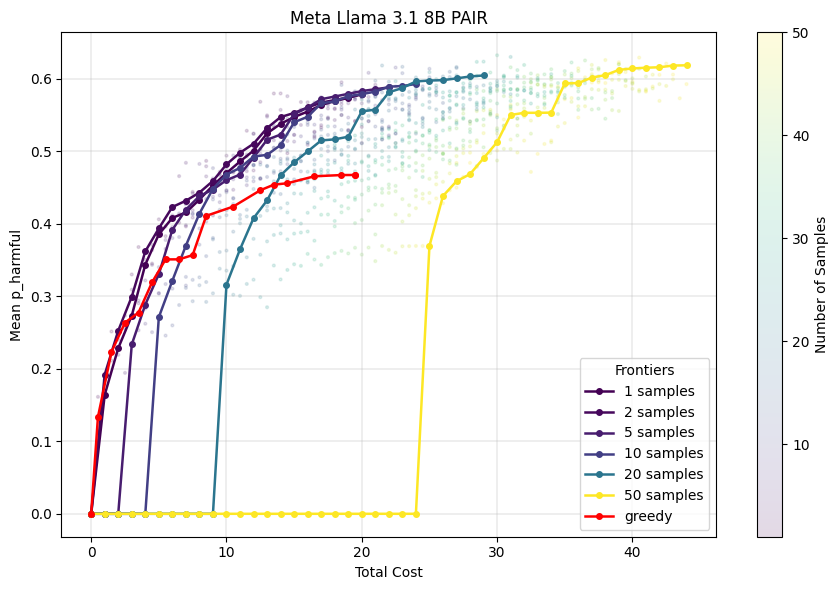

In [41]:
filter_by = {
    # "model": "google/gemma-3-1b-it",
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "pair",
    "attack_params": {
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
    },
    "dataset_params": {"idx": list(range(100))},
}
group_by = {("model",)}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "pair",
    "attack_params": {
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="Meta Llama 3.1 8B PAIR", sampling_cost_factor=0.5, cumulative=True)

filter_by = {
    # "model": "google/gemma-3-1b-it",
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "bon",
    "attack_params": {
        "generation_config": {"num_return_sequences": 1, "temperature": 1},
    },
    "dataset_params": {"idx": list(range(100))},
}
group_by = {("model",)}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
sampled_data = np.swapaxes(sampled_data, 1, 2)  # (B, n_steps, n_samples) -> (B, n_samples, n_steps) because one BoN step is more like a sample than a step

filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "direct",
    "attack_params": {
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="Meta Llama 3.1 8B BoN", sampling_cost_factor=1, cumulative=False)

100 for main
100 for baseline


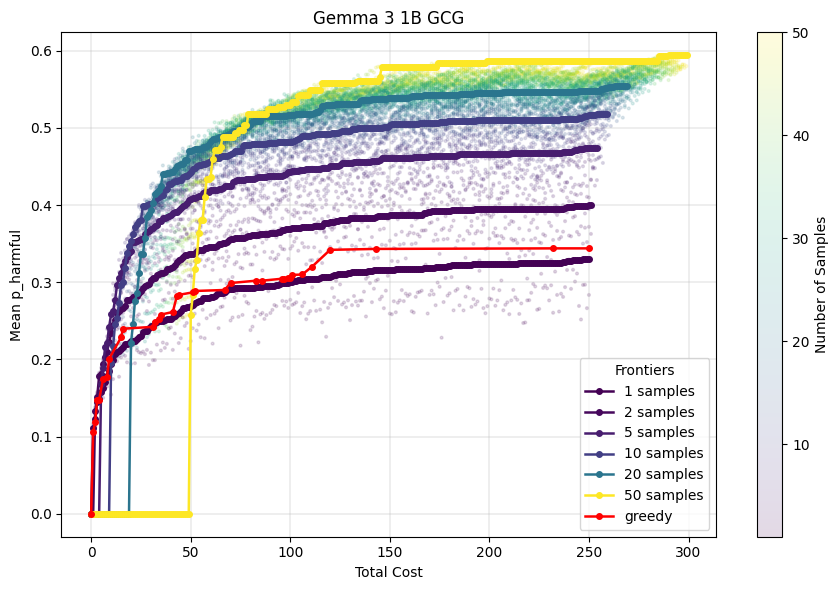

In [33]:
group_by = {("attack_params", "loss"), ("attack_params", "generation_config")}

filter_by = {
    "model": "google/gemma-3-1b-it",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(100))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
sampled_results = collect_results(paths)

filter_by = {
    "model": "google/gemma-3-1b-it",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(100))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
greedy_results = collect_results(paths)
assert len(sampled_results) == len(greedy_results) == 1
sampled_data = np.array(list(sampled_results.values())[0][("scores", "strong_reject", "p_harmful")])
greedy_data = np.array(list(greedy_results.values())[0][("scores", "strong_reject", "p_harmful")])
pareto_plot(sampled_data, baseline=greedy_data, title="Gemma 3 1B GCG", plot_envelope=False, plot_frontiers=True)

("attack_params.generation_config={'temperature': 0.7, 'top_p': 1.0, 'top_k': 0, 'max_new_tokens': 256, 'num_return_sequences': 100}", 'attack_params.loss=ce') 19
19 for main
20 for baseline


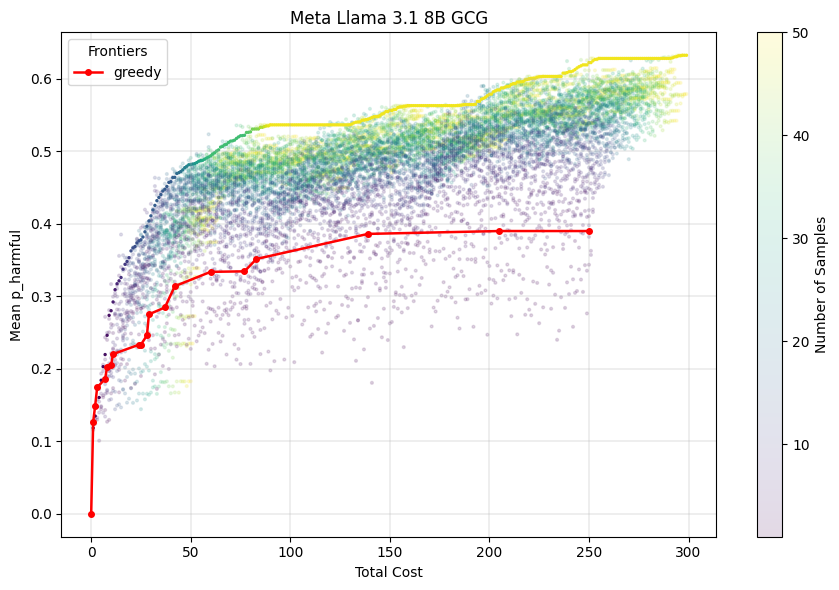

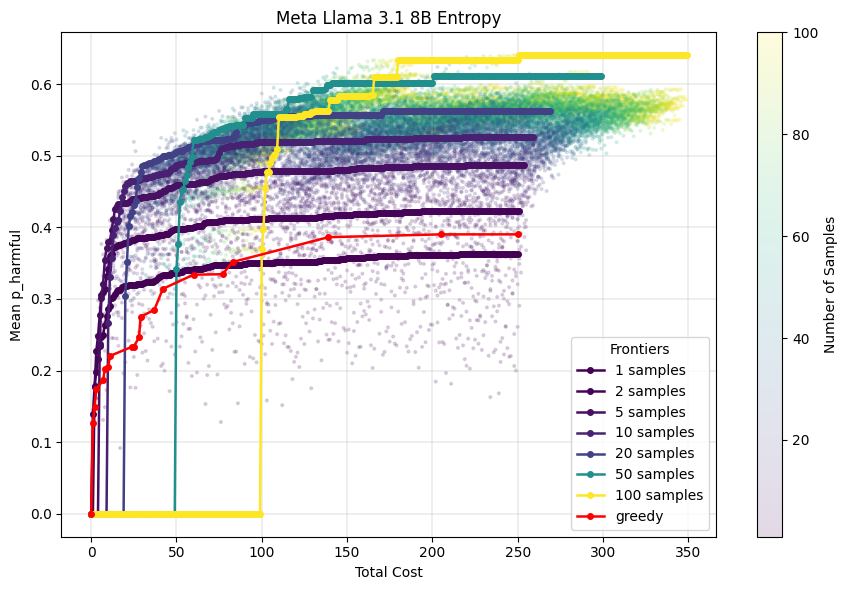

In [36]:
group_by = {("attack_params", "loss"), ("attack_params", "generation_config")}

filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 100, "temperature": 0.7},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)

filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
greedy_results = collect_results(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])[...,:50]
greedy_data = np.array(list(greedy_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
pareto_plot(sampled_data, baseline=greedy_data, plot_frontiers=False, plot_envelope=True, title="Meta Llama 3.1 8B GCG")


group_by = {("attack_params", "loss"), ("attack_params", "generation_config")}

filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 100, "temperature": 0.7},
        "loss": "entropy_first_token"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
sampled_results = collect_results(paths)

filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
greedy_results = collect_results(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
greedy_data = np.array(list(greedy_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
pareto_plot(sampled_data, baseline=greedy_data, plot_points=True, plot_frontiers=True, plot_envelope=False, title="Meta Llama 3.1 8B Entropy", verbose=False)

20 for main
21 for baseline


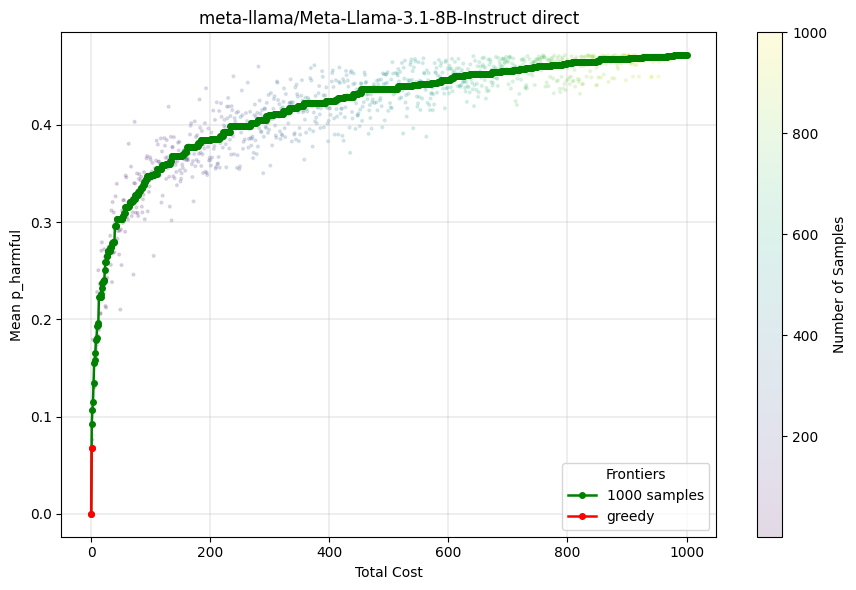

20 for main
20 for baseline


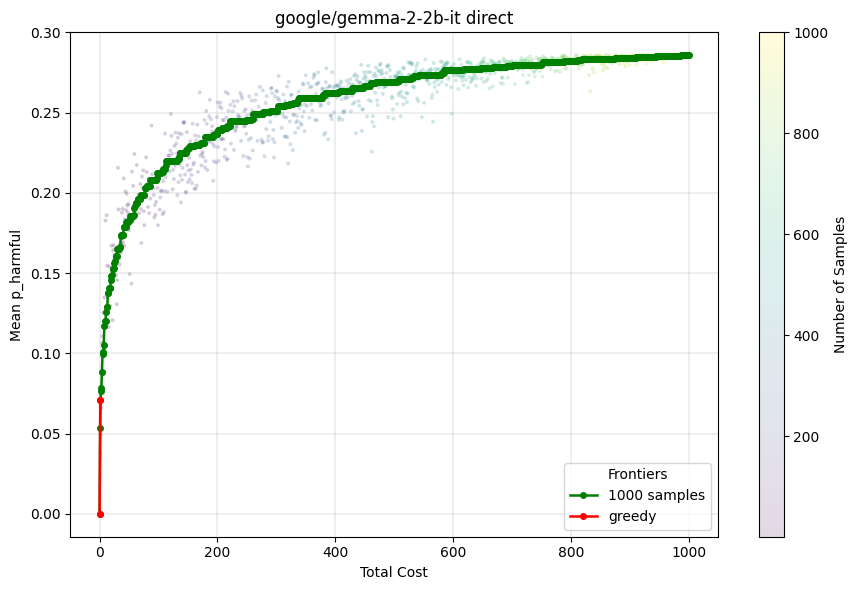

20 for main
20 for baseline


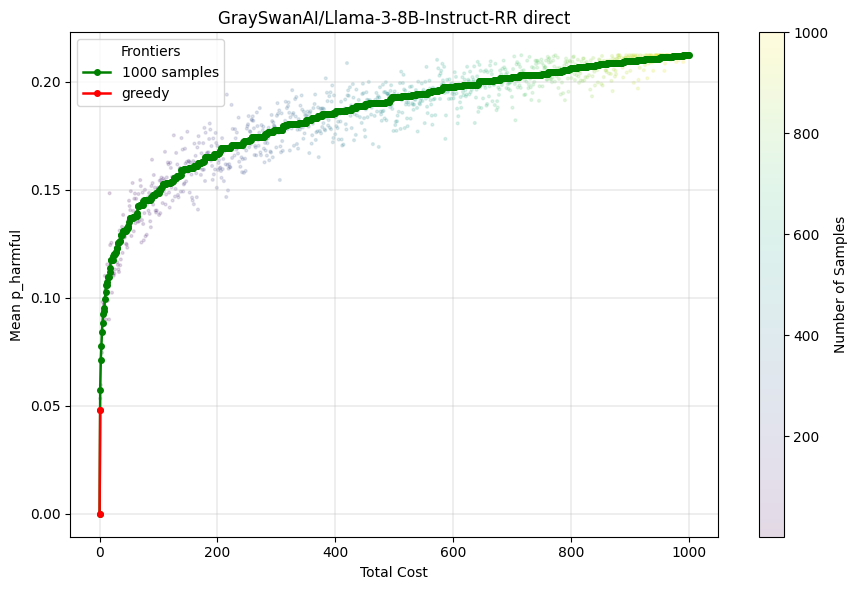

In [22]:
def make_pareto_plot(attack_args, baseline_args, title, *args, **kwargs):
    filter_by, group_by = attack_args
    paths = get_filtered_and_grouped_paths(filter_by, group_by)
    sampled_results = collect_results(paths)
    assert len(sampled_results) == 1
    sampled_data = np.array(
        list(sampled_results.values())[0][("scores", "strong_reject", "p_harmful")]
    )
    if baseline_args is not None:
        filter_by, group_by = baseline_args
        paths = get_filtered_and_grouped_paths(filter_by, group_by)
        greedy_results = collect_results(paths)
        assert len(greedy_results) == 1
        greedy_data = np.array(
            list(greedy_results.values())[0][("scores", "strong_reject", "p_harmful")]
        )
    else:
        greedy_data = None
    pareto_plot(sampled_data, baseline=greedy_data, title=title, *args, **kwargs)


models = ["meta-llama/Meta-Llama-3.1-8B-Instruct", "google/gemma-2-2b-it", "GraySwanAI/Llama-3-8B-Instruct-RR"]
attack = "direct"
dataset_params = {"idx": list(range(50))}
for model in models:
    make_pareto_plot(
        attack_args=(
            {
                "model": model,
                "attack": attack,
                "attack_params": {
                    "generation_config": {"num_return_sequences": 1000, "temperature": 0.7}
                },
                "dataset_params": dataset_params,
            },
            {("attack_params", "loss"), ("attack_params", "generation_config")},
        ),
        baseline_args=(
            {
                "model": model,
                "attack": attack,
                "attack_params": {
                    "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
                },
                "dataset_params": dataset_params,
            },
            {("attack_params", "loss"), ("attack_params", "generation_config")},
        ),
        title=f"{model} {attack}",
        plot_frontiers=False,
        plot_envelope=True,
    )

('model=google/gemma-3-1b-it',) 21
('model=google/gemma-3-1b-it',) 20
21 for main
20 for baseline


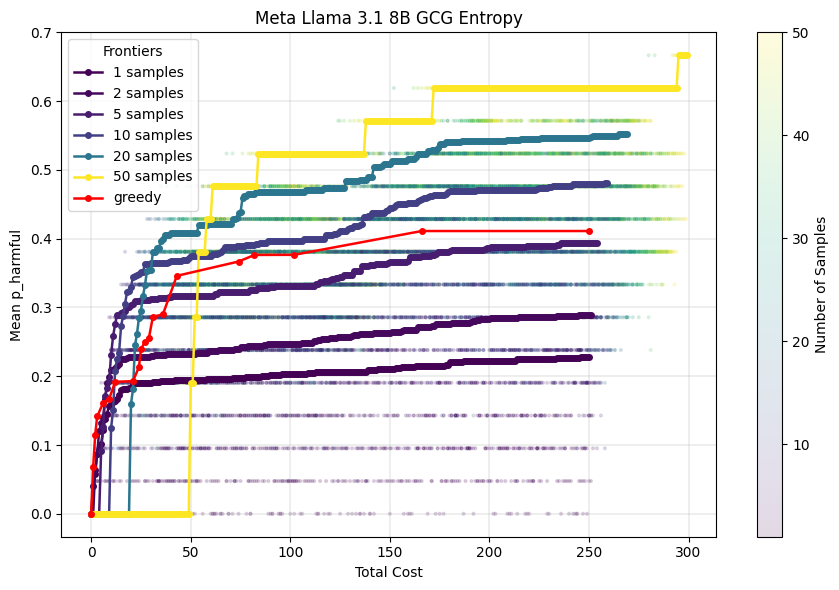

In [35]:
filter_by = {
    "model": "google/gemma-3-1b-it",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
        "loss": "entropy_adaptive"
    },
    "dataset_params": {"idx": list(range(100))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
filter_by = {
    "model": "google/gemma-3-1b-it",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# sampled_data = sampled_data > 0.5
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="Meta Llama 3.1 8B GCG Entropy")

In [17]:
filter_by = {
    "attack": "gcg",
}
group_by = {("model",), ("attack_params", "generation_config", "num_return_sequences")}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))

('attack_params.generation_config.num_return_sequences=1', 'model=Qwen/Qwen2.5-0.5B-Instruct') 40
('attack_params.generation_config.num_return_sequences=1', 'model=google/gemma-2-2b-it') 185
('attack_params.generation_config.num_return_sequences=1', 'model=meta-llama/Meta-Llama-3.1-8B-Instruct') 200
('attack_params.generation_config.num_return_sequences=1', 'model=meta-llama/Llama-2-7b-chat-hf') 298
('attack_params.generation_config.num_return_sequences=1', 'model=microsoft/Phi-3-mini-4k-instruct') 197
('attack_params.generation_config.num_return_sequences=1', 'model=GraySwanAI/Mistral-7B-Instruct-RR') 199
('attack_params.generation_config.num_return_sequences=1', 'model=LLM-LAT/robust-llama3-8b-instruct') 260
('attack_params.generation_config.num_return_sequences=10', 'model=meta-llama/Meta-Llama-3-8B-Instruct') 21
('attack_params.generation_config.num_return_sequences=10', 'model=GraySwanAI/Llama-3-8B-Instruct-RR') 20
('attack_params.generation_config.num_return_sequences=10', 'model

('model=google/gemma-3-1b-it',) 20
('model=google/gemma-3-1b-it',) 20
20 for main
20 for baseline


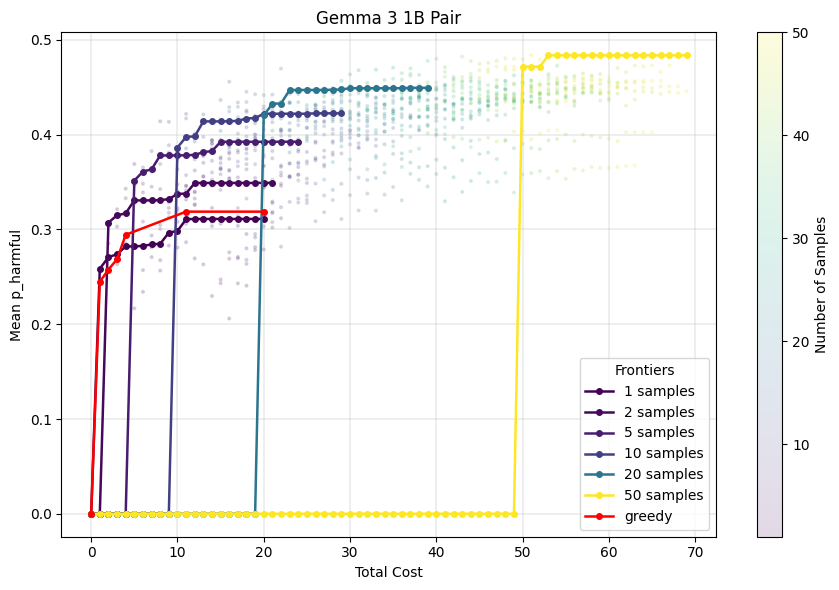

In [16]:
filter_by = {
    "model": "google/gemma-3-1b-it",
    "attack": "pair",
    "attack_params": {
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
    },
    "dataset_params": {"idx": list(range(100))},
}
group_by = {("model",)}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
filter_by = {
    "model": "google/gemma-3-1b-it",
    "attack": "pair",
    "attack_params": {
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="Gemma 3 1B Pair")

In [29]:
filter_by = {
    # "model": "google/gemma-3-1b-it",
    # "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "autodan",
    # "attack_params": {
    #     "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
    # },
    # "dataset_params": {"idx": list(range(100))},
}
group_by = {("model",)}
paths = get_filtered_and_grouped_paths(filter_by, group_by)



sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
filter_by = {
    # "model": "google/gemma-3-1b-it",
    # "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "autodan",
    "attack_params": {
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="Meta Llama 3.1 8B Pair")

('model=meta-llama/Meta-Llama-3.1-8B-Instruct',) 40
('model=google/gemma-3-1b-it',) 4


FileNotFoundError: [Errno 2] No such file or directory: '/ceph/ssd/staff/beyer/llm-quick-check/outputs/2025-05-19/11-42-21/0/run.json'

('model=google/gemma-2-2b-it',) 20
('model=google/gemma-2-2b-it',) 20


20 for main
20 for baseline


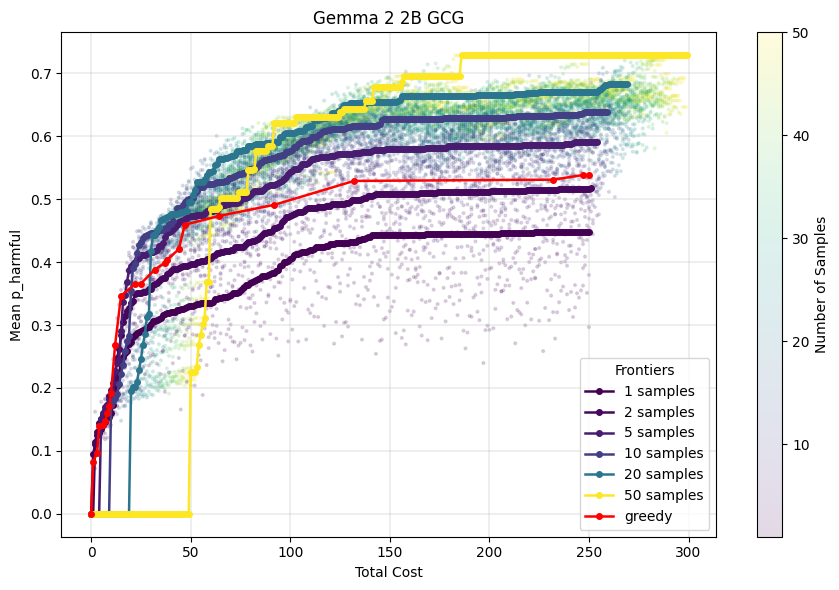

In [46]:
filter_by = {
    "model": "google/gemma-2-2b-it",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
filter_by = {
    "model": "google/gemma-2-2b-it",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="Gemma 2 2B GCG")

('model=GraySwanAI/Llama-3-8B-Instruct-RR',) 20
('model=GraySwanAI/Llama-3-8B-Instruct-RR',) 20
20 for main
20 for baseline


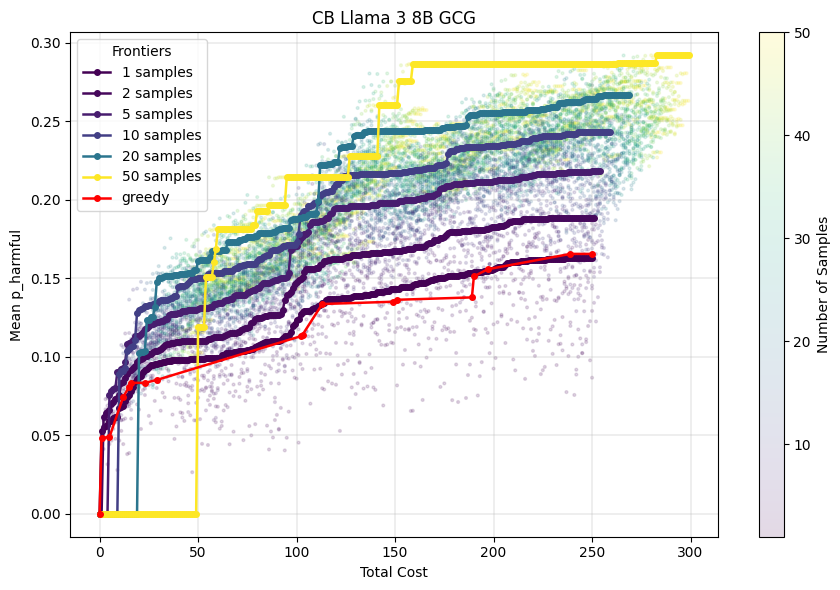

In [47]:
filter_by = {
    "model": "GraySwanAI/Llama-3-8B-Instruct-RR",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(50))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
filter_by = {
    "model": "GraySwanAI/Llama-3-8B-Instruct-RR",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(50))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="CB Llama 3 8B GCG")

('model=meta-llama/Meta-Llama-3.1-8B-Instruct',) 17
('model=meta-llama/Meta-Llama-3.1-8B-Instruct',) 20
17 for main
20 for baseline


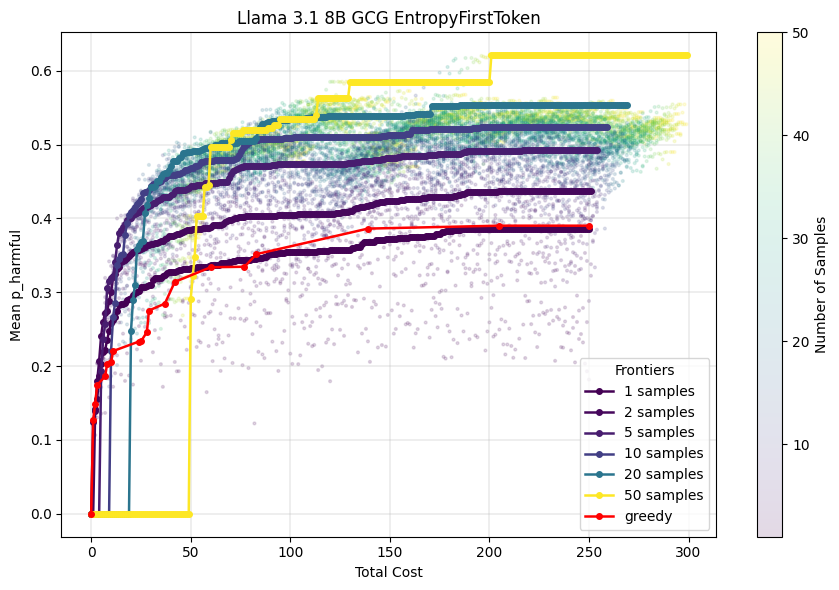

In [48]:
filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 50, "temperature": 0.7},
        "loss": "entropy_first_token"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
sampled_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
filter_by = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "attack": "gcg",
    "attack_params": {
        "num_steps": 250,
        "token_selection": "default",
        "generation_config": {"num_return_sequences": 1, "temperature": 0.0},
        "loss": "ce"
    },
    "dataset_params": {"idx": list(range(20))},
}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
for k, v in paths.items():
    print(k, len(v))
sampled_results = collect_results(paths)
# print(paths)
baseline_data = np.array(list(sampled_results.values())[0][('scores', 'strong_reject', 'p_harmful')])
# print(sampled_data.shape)
pareto_plot(sampled_data, baseline_data, title="Llama 3.1 8B GCG EntropyFirstToken")

In [ ]:
group_by = {("attack_params", "tie_logits"), ("dataset_params", "idx")}

filter_by = {"model": "GraySwanAI/Llama-3-8B-Instruct-RR", "attack": "pgd", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50, "temperature": 0.7}, "tie_logits": (0, 1.0)}, "dataset_params": {"idx": list(range(20))}}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
filter_by = {"model": "GraySwanAI/Llama-3-8B-Instruct-RR", "attack": "pgd", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 1, "temperature": 0.0}, "tie_logits": (0, 1.0)}, "dataset_params": {"idx": list(range(20))}}
paths |= get_filtered_and_grouped_paths(filter_by, group_by)
results = collect_results(paths)
metrics = [("scores", "strong_reject", "p_harmful")]
plot_metrics_grouped_by_key(results, metrics, title=filter_by, verbose=True)

In [ ]:
group_by = {("dataset_params", "idx")}

filter_by = {"model": "meta-llama/Meta-Llama-3-8B-Instruct", "attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 1, "temperature": 0.0}, "loss": "ce"}, "dataset_params": {"idx": list(range(20))}}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
results = collect_results(paths)
metrics = ["time_taken"]
reduce_fn = {"runs": np.mean, "steps": np.cumsum, "samples": lambda x, axis: x}
plot_metrics_grouped_by_key(results, metrics, title=filter_by, reduce_fn=reduce_fn, verbose=True)

In [ ]:
group_by = {"attack_name"}

filter_by = {"model": "google/gemma-3-12b-it"}
paths = get_filtered_and_grouped_paths(filter_by, group_by)
results = collect_results(paths)
metrics = ["time_taken"]
reduce_fn = {"runs": np.mean, "steps": np.cumsum, "samples": lambda x, axis: x}
plot_metrics_grouped_by_key(results, metrics, title=filter_by, reduce_fn=reduce_fn, verbose=True)

In [ ]:
filter_by = {"model": "meta-llama/Meta-Llama-3-8B-Instruct", "attack": "gcg", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50}, "loss": ("kl_allowed", "entropy", "ce"), "token_selection": "default"}}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("attack_params", "loss")}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = ["loss", ("scores", "strong_reject", "p_harmful")]
make_plot(filter_by, group_by, metrics, verbose=True)

In [ ]:
group_by = {"model", ("attack_params", "token_selection")}
metrics = ["loss", ("scores", "strong_reject", "p_harmful")]
for model in ["Qwen/Qwen2.5-0.5B-Instruct", "google/gemma-2-2b-it", "meta-llama/Llama-2-7b-chat-hf", "meta-llama/Meta-Llama-3.1-8B-Instruct", "LLM-LAT/robust-llama3-8b-instruct", "GraySwanAI/Mistral-7B-Instruct-RR", "microsoft/Phi-3-mini-4k-instruct"]:
    filter_by = {"model": model, "attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 1}}}
    make_plot(filter_by, group_by, metrics)

In [ ]:
# which attributes do you want to compare/group by?
group_by = { ("attack_params", "loss")}
metrics = [("scores", "strong_reject", "p_harmful")]
for i in range(20):
    filter_by = {"model": "LLM-LAT/robust-llama3-8b-instruct", "attack": "gcg", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50}}, "dataset_params": {"idx": i}}
    make_plot(filter_by, group_by, metrics)

In [ ]:
# which attributes do you want to compare/group by?
group_by = {"model", ("attack_params", "loss")}
metrics = ["loss", ("scores", "strong_reject", "p_harmful")]
filter_by = {"attack": "gcg", "attack_params": {"num_steps": 250, "generation_config": {"num_return_sequences": 50}}, "dataset_params": {"idx": 0}}
make_plot(filter_by, group_by, metrics)

## Tables

In [18]:
def table_for_results(results, metrics, reduce_fn, verbose=False):
    df = pd.DataFrame()
    for metric in metrics:
        # 2) Gather each group's initial value for sorting
        initial_values = []
        for group_key, group_results in results.items():
            if metric in group_results:
                avg_points = [np.mean(seq) for seq in group_results[metric]]
                initial_values.append((group_key, np.mean(avg_points)))
        # 3) Sort by that initial value
        sorted_groups = sorted(initial_values, key=lambda x: x[1], reverse=True)

        for group_key, _ in sorted_groups:
            if metric in results[group_key]:
                metric_values = results[group_key][metric]
            else:
                if verbose:
                    print(f"Metric {metric} not found for group {group_key}")
                continue
            # align lengths
            min_len = min(len(seq) for seq in metric_values)
            aligned = np.array([seq[:min_len] for seq in metric_values])  # (N, N_Steps) or (N, N_Steps, N_per_step)

            if verbose:
                print(f"{group_key}: plotting {metric} with {aligned.shape[0]} runs")

            # ---------- core statistics (shared) ----------
            min_len = min(len(seq) for seq in metric_values)
            aligned = np.array([seq[:min_len] for seq in metric_values])         # (n_runs, n_steps, n_per_step)

            # over       runs,  steps, samples
            # basic summary stats you may want in the table
            if aligned.ndim == 2:
                aligned = aligned[..., None]
            custom_vals = reduce_fn["samples"](aligned, axis=-1)
            custom_vals = reduce_fn["steps"](custom_vals, axis=-1)
            custom_vals = reduce_fn["runs"](custom_vals, axis=-1)
            if isinstance(custom_vals, float):
                custom_vals = np.array([custom_vals])
            # long/tidy format → easier to concat many groups later
            df = pd.concat([df, pd.DataFrame({
                    "metric":      [metric for _ in custom_vals],
                    "group":       [str(group_key) for _ in custom_vals],
                    "value":       custom_vals,
            })])
    if verbose:
        print(df.head())
    return df


def make_table(filter_by, group_by, metrics, reduce_fn={"runs": np.mean, "steps": np.max, "samples": np.max}) -> pd.DataFrame:
    paths = get_filtered_and_grouped_paths(filter_by, group_by)
    results = collect_results(paths)
    return table_for_results(results, metrics, reduce_fn)

In [22]:
for model in [
    "GraySwanAI/Llama-3-8B-Instruct-RR",
    # "LLM-LAT/robust-llama3-8b-instruct",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Meta-Llama-3-8B-Instruct",
    "google/gemma-3-1b-it",
    "Unispac/Llama2-7B-Chat-Augmented",
]:
    filter_by = {
        "model": model,
        "attack": "gcg",
        "attack_params": {
            "num_steps": 250,
            "generation_config": {"num_return_sequences": 50},
            "loss": ("ce", "entropy_adaptive"),
            "use_prefix_cache": True,
        },
        "dataset_params": {"idx": list(range(75))},
    }
    group_by = {"model", ("attack_params", "loss")}
    metrics = [("scores", "strong_reject", "p_harmful")]

    # for tables, we need to find a way to reduce the data to a single value per group
    # here we use the per-sample max, per-step max, and mean over runs
    reduce_fn = {"runs": np.mean, "steps": lambda x, axis: x[..., -1], "samples": lambda x, axis: np.any(x > 0.5, axis=axis)}

    df = make_table(filter_by, group_by, metrics, reduce_fn)
    # Pretty print the dataframe, sorting by value column, and making a separate table for each metric
    for metric_name in metrics:
        print(f"\n--- {metric_name} ---")
        metric_df = df[df["metric"] == metric_name].sort_values(
            by="value", ascending=False
        )
        display(metric_df.reset_index(drop=True)[["group", "value"]])


--- ('scores', 'strong_reject', 'p_harmful') ---


group     value
0                ('attack_params.loss=ce', 'model=GraySwanAI/Llama-3-8B-Instruct-RR')  0.068029
1  ('attack_params.loss=entropy_adaptive', 'model=GraySwanAI/Llama-3-8B-Instruct-RR')  0.056496


--- ('scores', 'strong_reject', 'p_harmful') ---


group     value
0                ('attack_params.loss=ce', 'model=meta-llama/Meta-Llama-3.1-8B-Instruct')  0.354421
1  ('attack_params.loss=entropy_adaptive', 'model=meta-llama/Meta-Llama-3.1-8B-Instruct')  0.333412


--- ('scores', 'strong_reject', 'p_harmful') ---


group     value
0                ('attack_params.loss=ce', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.300335
1  ('attack_params.loss=entropy_adaptive', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.276462


--- ('scores', 'strong_reject', 'p_harmful') ---


group     value
0                ('attack_params.loss=ce', 'model=google/gemma-3-1b-it')  0.337255
1  ('attack_params.loss=entropy_adaptive', 'model=google/gemma-3-1b-it')  0.158046


--- ('scores', 'strong_reject', 'p_harmful') ---


group     value
0                ('attack_params.loss=ce', 'model=Unispac/Llama2-7B-Chat-Augmented')  0.098609
1  ('attack_params.loss=entropy_adaptive', 'model=Unispac/Llama2-7B-Chat-Augmented')  0.045958

In [20]:
filter_by = {"model": "LLM-LAT/robust-llama3-8b-instruct", "attack": "gcg", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50}}}


df = make_table(filter_by, group_by, metrics, reduce_fn)
# Pretty print the dataframe, sorting by value column, and making a separate table for each metric
for metric_name in metrics:
    print(f"\n--- {metric_name} ---")
    metric_df = df[df['metric'] == metric_name].sort_values(by='value', ascending=False)
    display(metric_df.reset_index(drop=True)[['group', 'value']])




--- ('scores', 'strong_reject', 'p_harmful') ---


group     value
0                                  ('attack_params.loss=ce', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.519213
1           ('attack_params.loss=smallmax_prob_first_token', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.229268
2                 ('attack_params.loss=entropy_first_token', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.214352
3                    ('attack_params.loss=entropy_adaptive', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.200788
4               ('attack_params.loss=entropy_no_disallowed', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.178864
5                       ('attack_params.loss=smallmax_prob', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.164926
6   ('attack_params.loss=entropy_first_token_high_then_low', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.153020
7                ('attack_params.loss=smallmax_first_token', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.145861
8                          ('attack_params.loss=kl_allowed', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.097910
9                             ('attack_params.loss=entropy', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.088573
10                           ('attack_params.loss=smallmax', 'model=LLM-LAT/robust-llama3-8b-instruct')  0.087905

In [21]:
filter_by = {"model": "meta-llama/Meta-Llama-3-8B-Instruct", "attack": "gcg", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50}}}

df = make_table(filter_by, group_by, metrics, reduce_fn)
# Pretty print the dataframe, sorting by value column, and making a separate table for each metric
for metric_name in metrics:
    print(f"\n--- {metric_name} ---")
    metric_df = df[df['metric'] == metric_name].sort_values(by='value', ascending=False)
    display(metric_df.reset_index(drop=True)[['group', 'value']])




--- ('scores', 'strong_reject', 'p_harmful') ---


group     value
0   ('attack_params.loss=entropy_first_token_high_then_low', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.842809
1                    ('attack_params.loss=entropy_adaptive', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.794527
2                 ('attack_params.loss=entropy_first_token', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.787864
3                                  ('attack_params.loss=ce', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.731579
4                ('attack_params.loss=smallmax_first_token', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.726507
5                          ('attack_params.loss=kl_allowed', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.699243
6           ('attack_params.loss=smallmax_prob_first_token', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.553547
7                       ('attack_params.loss=smallmax_prob', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.417179
8               ('attack_params.loss=entropy_no_disallowed', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.402618
9                             ('attack_params.loss=entropy', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.362645
10                           ('attack_params.loss=smallmax', 'model=meta-llama/Meta-Llama-3-8B-Instruct')  0.274712

In [1]:
# Here's an example which finds all gcg runs with 250 steps and 1 return sequence and cross entropy loss or entropy adaptive loss
filter_by = {"attack": "pgd", "attack_params": {"num_steps": 100, "generation_config": {"num_return_sequences": 50}, "loss": ("entropy_adaptive", "ce")}}
# We then make separate lines for each token selection strategy.
# All other attributes are averaged over (e.g., model, dataset index, etc.).
group_by = {("attack_params", "loss"), "model"}
# We make two subplots, one for the loss and one for the strong reject p_harmful score.
metrics = [("scores", "strong_reject", "p_harmful")]
reduce_fn = {"runs": np.mean, "steps": np.max, "samples": np.max}
df = make_table(filter_by, group_by, metrics, reduce_fn)
# Pretty print the dataframe, sorting by value column, and making a separate table for each metric
for metric_name in metrics:
    print(f"\n--- {metric_name} ---")
    metric_df = df[df['metric'] == metric_name].sort_values(by='value', ascending=False)
    display(metric_df.reset_index(drop=True)[['group', 'value']])

NameError: name 'np' is not defined